# Flow predictor

Data processing, model training and analysis

In [79]:
%matplotlib widget
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons, CheckButtons
plt.close("all")

## Data pre-processing

In [80]:
# Initialise DataFrame and discard non-numeric data
initial_df = pd.read_excel("data.xlsx", header=[0, 1], index_col=0)

initial_df.columns = initial_df.columns.set_levels(["rain", "flow"], level=0)
initial_df = initial_df.rename_axis(index="date")

initial_df = initial_df.apply(pd.to_numeric, errors="coerce")
initial_df = initial_df[initial_df >= 0]
initial_df["rain"] = initial_df["rain"][initial_df["rain"]<=279]
initial_df.dropna(inplace=True)


# Copy data as we will use the initial frame for visualization
df = initial_df.copy()
df.columns = df.columns.droplevel()
df = df[np.abs(df - df.std()) <= df.mean() + 3 * df.std()]
df["Skelton"] = df["Skelton"].shift(1)

df.dropna(inplace=True)
print(initial_df.head().to_string() + "\n")
print(df.head().to_string())


                flow                                        rain                                    
           Crakehill Skip Bridge Westwick Skelton Arkengarthdale East Cowton Malham Tarn Snaizeholme
date                                                                                                
1993-01-01     10.40       4.393    9.291   26.10            0.0         0.0         0.0         4.0
1993-01-02      9.95       4.239    8.622   24.86            0.0         0.0         0.8         0.0
1993-01-03      9.46       4.124    8.057   23.60            0.0         0.0         0.8         0.0
1993-01-04      9.41       4.363    7.925   23.47            2.4        24.8         0.8        61.6
1993-01-05     26.30      11.962   58.704   60.70           11.2         5.6        33.6       111.2

            Crakehill  Skip Bridge  Westwick  Skelton  Arkengarthdale  East Cowton  Malham Tarn  Snaizeholme
date                                                                              

## Data visualization

### Culling dataset by varying number of std devs

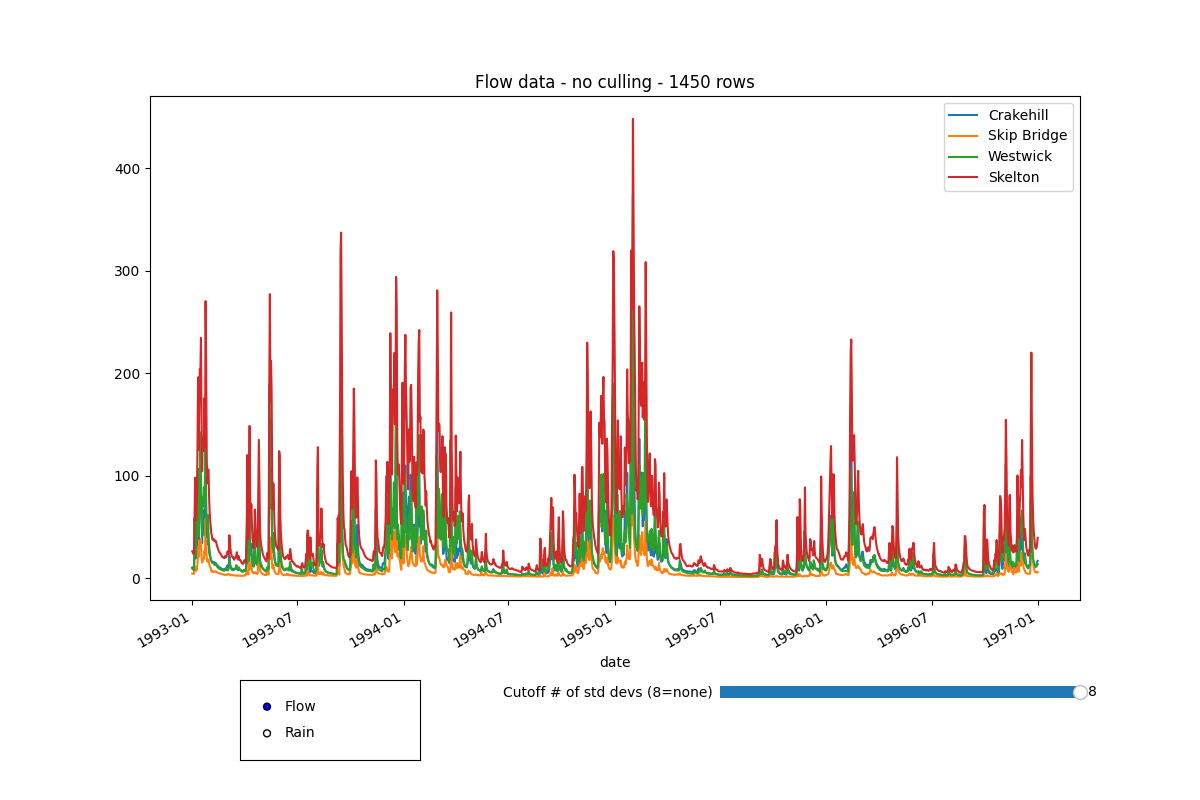

In [81]:
plt.close("all")

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
fig, ax_graph = plt.subplots()
ax_buttons = fig.add_axes([0.2, 0.05, 0.15, 0.1])
ax_slider = fig.add_axes([0.6, 0.12, 0.3, 0.03])
initial_df["flow"].plot(ax=ax_graph, title=f"Flow data - no culling - {initial_df.shape[0]} rows")



# ============================== COMPONENTS ================================


# Radio buttons for flow/rain

dataset_radio = RadioButtons(ax=ax_buttons, labels=["Flow", "Rain"])



# Slider for # of std devs

sd_slider = Slider(ax=ax_slider, label="Cutoff # of std devs (8=none)",
                   valmin=1, valmax=8, valinit=8, valstep=1)

# ======================== EVENT HANDLER FUNCTIONS =======================

def std_update(val):
    dataset = dataset_radio.value_selected
    sd = sd_slider.val

    std_data = initial_df.copy()
    title_text = f"{dataset} data - no culling - {std_data.shape[0]} rows"
    if sd != 8:
        std_data = std_data[np.abs(std_data - std_data.std()) <= std_data.mean() + sd * std_data.std()]
        std_data.dropna(inplace=True)
        title_text = f"{dataset} data - culling values >{sd} std devs from mean - {std_data.shape[0]} rows"

    ax_graph.clear()
    std_data[dataset.lower()].plot(ax=ax_graph, title=title_text)
    fig.subplots_adjust(bottom=0.25)
    fig.canvas.draw()


dataset_radio.on_clicked(std_update)
sd_slider.on_changed(std_update)



# Figure styling
fig.subplots_adjust(bottom=0.25)
fig.set_size_inches((12, 8))
fig.canvas.header_visible = False

### Plot predictor vs predictand with transformations

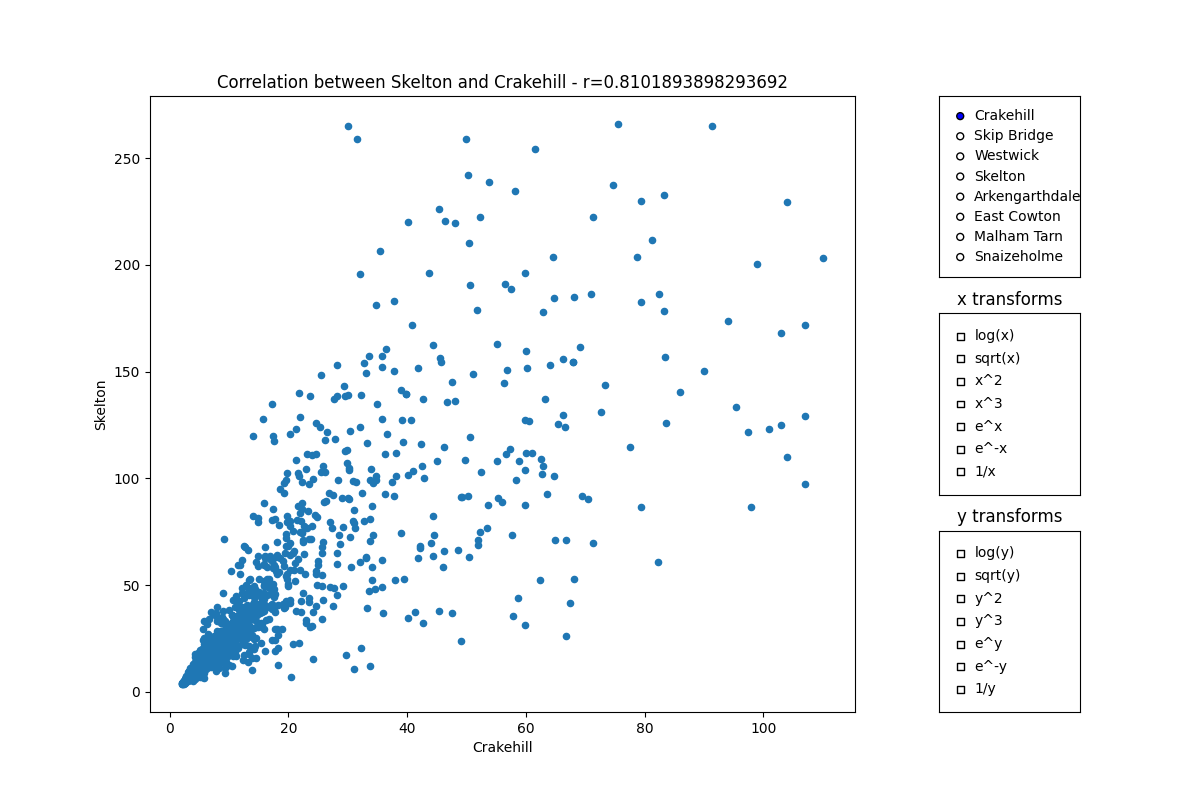

In [136]:
plt.close("all")

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
corr_fig, corr_axes = plt.subplot_mosaic(
    [
        ["main", "xdata"],
        ["main", "x_transforms"],
        ["main", "y_transforms"],
    ],
    width_ratios=[5, 1])
corr_axes["x_transforms"].set_title("x transforms")
corr_axes["y_transforms"].set_title("y transforms")

corr_data = df.copy()
pd_init_x = corr_data.columns[0]
corr_init = corr_data.corr()["Skelton"][pd_init_x]
corr_data.plot(x=pd_init_x, y="Skelton", kind="scatter", ax=corr_axes["main"],
               title=f"Correlation between Skelton and {pd_init_x} - r={corr_init}")

# ============================== COMPONENTS ================================


# Radio buttons for predictor to plot

predictor_radio = RadioButtons(ax=corr_axes["xdata"],
                               labels=corr_data.columns)

# Check buttons for predictand transforms

def transform_labels(axis):
    return [f"log({axis})",
            f"sqrt({axis})",
            f"{axis}^2",
            f"{axis}^3",
            f"e^{axis}",
            f"e^-{axis}",
            f"1/{axis}",]

x_transform_checks = CheckButtons(ax=corr_axes["x_transforms"],
                                labels=transform_labels("x"))


# Check buttons for predictor transforms

y_transform_checks = CheckButtons(ax=corr_axes["y_transforms"],
                                  labels=transform_labels("y"))

# ======================== EVENT HANDLER FUNCTIONS =======================

def apply_transforms(checks, data):
    transforms = checks.get_status()
    if transforms[0]: data = data.apply(np.log)
    if transforms[1]: data = data.apply(np.sqrt)
    if transforms[2]: data = data.apply(np.square)
    if transforms[3]: data = data.apply(lambda x: np.power(x,3))
    if transforms[4]: data = data.apply(lambda x: np.power(np.e,x))
    if transforms[5]: data = data.apply(lambda x: np.power(np.e, -x))
    if transforms[6]: data = data.apply(lambda x: 1/x if x!=0 else 0)
    return data

def pd_update(val):
    prd = predictor_radio.value_selected

    c_data = corr_data.copy()

    c_data[prd] = apply_transforms(x_transform_checks, c_data[prd])
    c_data["Skelton"] = apply_transforms(y_transform_checks, c_data["Skelton"])

    corr = c_data.corr()["Skelton"][prd]

    corr_axes["main"].clear()
    c_data.plot(x=prd, y="Skelton", kind="scatter", ax=corr_axes["main"],
                title=f"Correlation between Skelton and {prd} - r={corr:.4f}")
    corr_fig.canvas.draw()

predictor_radio.on_clicked(pd_update)
x_transform_checks.on_clicked(pd_update)
y_transform_checks.on_clicked(pd_update)

# Figure styling
corr_fig.set_size_inches((12, 8))
corr_fig.canvas.header_visible = False